In [1939]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1940]:
def lin(currentno, skill, totalno):
    return skill

def inc(currentno, skill, totalno):
    # return skill * (0.85 + 0.3 * (currentno/totalno)**0.5)
    return skill + (((1-skill)**2) * (currentno/totalno)**0.5)

def dec(currentno, skill, totalno):
    #return skill * (1.15 - 0.3 * (currentno/totalno)**1.5)
    return skill - (((1-skill)**2) * (currentno/totalno)**0.5)*0.5

def type_always_pos(liste, diminish_rounds, sensitivity, treatment):
    if treatment == "positive":
        return [i + sensitivity*i*(0.12* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    elif treatment == "negative":
        return [i + sensitivity*i*(0.06* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    else:
        return [i for index, i in enumerate(liste)]

def type_always_neg(liste, diminish_rounds, sensitivity, treatment):
    if treatment == "positive":
        return [i - sensitivity*i*(0.06* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    elif treatment == "negative":
        return [i - sensitivity*i*(0.12* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    else:
        return [i for index, i in enumerate(liste)]

def type_none(liste, diminish_rounds, sensitivity, treatment):
    return [i for index, i in enumerate(liste)]

def type_pos_neg(liste, diminish_rounds, sensitivity, treatment):
    if treatment == "positive":
        return [i + sensitivity*i*(0.12* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    elif treatment == "negative":
        return [i - sensitivity*i*(0.12* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    else:
        return [i for index, i in enumerate(liste)]

def type_neg_pos(liste, diminish_rounds, sensitivity, treatment):
    if treatment == "positive":
        return [i - sensitivity*i*(0.06* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    elif treatment == "negative":
        return [i + sensitivity*i*(0.06* max(0,(1-(index/ min(len(liste), diminish_rounds*5))**2 )) ) for index, i in enumerate(liste)]
    else:
        return [i for index, i in enumerate(liste)]
    


def moving_average(values, window_size):
    moving_averages = []
    na_count = (window_size - 1) // 2  # Number of 'NA' values to add on each side
    
    # Add 'NA' values at the beginning
    for _ in range(na_count):
        moving_averages.append(None)
    
    # Calculate the moving average for each window
    for i in range(len(values) - window_size + 1):
        window = values[i:i+window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    
    # Add 'NA' values at the end
    for _ in range(na_count):
        moving_averages.append(None)
    
    return moving_averages

def moving_average_split(values, window_size, treatment_obs):

    return moving_average(values[:treatment_obs], window_size) + moving_average(values[treatment_obs:], window_size)




def create_pers_wordlist(wordlist, multiplier):
    
    wordlist_new = [i*multiplier + random.uniform(-1,1)*multiplier for i in wordlist]
    wordlist_cumulative = []
    count = 0

    for time in wordlist_new:
        count += time
        wordlist_cumulative += [count]

    wordlist_cum_final = [i for i in wordlist_cumulative if i < 2422]
    wordlist_new_final = wordlist_new[:len(wordlist_cum_final)]

    return wordlist_new_final, wordlist_cum_final, len(wordlist_cum_final)



def create_pers_obs(subject_ID, treatment, treatment_round, variance, wordlist):
        


    temp_df = pd.DataFrame()

    multiplier = random.uniform(0.85,1.15)
    sensitivity = random.uniform(0.9,1.1)
    diminish_rounds = random.choice([3,4,4,5,5,5,6,6,7])
    response_type = random.choice(["always_pos", "always_pos","always_pos", "none","none","pos_neg","pos_neg","pos_neg","pos_neg",])
    trend = random.choice(["lin", "lin", "lin"])

    single_time, cumulative_time, no_obs = create_pers_wordlist(wordlist, multiplier)
    
    temp_df["subjectID"] = [subject_ID]*no_obs
    temp_df["timestamp"] = cumulative_time
    temp_df["drawing_time"] = single_time




    temp_df["observationID"] = [i for i in range(1,no_obs+1)]
    skill = (np.random.beta(2,2) * 0.5 + 0.25)*multiplier
    temp_df["skill"] = [skill]*no_obs

    if trend == "lin":
        tl = [lin(i, skill, max(temp_df["timestamp"])) for i in temp_df["timestamp"]]
    if trend == "inc":
        tl = [inc(i, skill, max(temp_df["timestamp"])) for i in temp_df["timestamp"]]
    if trend == "dec":
        tl = [dec(i, skill, max(temp_df["timestamp"])) for i in temp_df["timestamp"]]

    temp_df["trend"] = tl

    temp_df["variance_trend"] = [min(max(0,(1+random.uniform(-variance,variance)) * i),1) for i in temp_df["trend"]]

    feedbacklist = [i for i in temp_df["variance_trend"]]
    for i in range(2, len(feedbacklist),5):
        avg = sum(feedbacklist[i-2:i+3]) / len(feedbacklist[i-2:i+3])  # Calculate the average of current and two previous entries
        feedbacklist[i-2:i+3] = [avg] * len(feedbacklist[i-2:i+3]) 
    temp_df["feedback"] = feedbacklist


    treatment_obs = treatment_round * 5
    if treatment == "negative":
        temp_df["treat_neg"] = [1] * no_obs
        temp_df["treat_pos"] = [0] * no_obs
        temp_df["post_treat"] = [0]*treatment_obs + [1]*(no_obs-treatment_obs)

    if treatment == "positive":
        temp_df["treat_neg"] = [0] * no_obs
        temp_df["treat_pos"] = [1] * no_obs
        temp_df["post_treat"] = [0]*treatment_obs + [1]*(no_obs-treatment_obs)
    
    if treatment == "control":
        temp_df["treat_neg"] = [0] * no_obs
        temp_df["treat_pos"] = [0] * no_obs
        temp_df["post_treat"] = [0]*treatment_obs + [1]*(no_obs-treatment_obs)


    if response_type == "always_pos":
        temp_df["quality"] = [i for i in temp_df["variance_trend"][:treatment_obs]] + type_always_pos([i for i in temp_df["variance_trend"][treatment_obs:]], diminish_rounds, sensitivity, treatment)

    if response_type == "always_neg":
        temp_df["quality"] = [i for i in temp_df["variance_trend"][:treatment_obs]] + type_always_neg([i for i in temp_df["variance_trend"][treatment_obs:]], diminish_rounds, sensitivity, treatment)

    if response_type == "none":
        temp_df["quality"] = [i for i in temp_df["variance_trend"][:treatment_obs]] + type_none([i for i in temp_df["variance_trend"][treatment_obs:]], diminish_rounds, sensitivity, treatment)

    if response_type == "pos_neg":
        temp_df["quality"] = [i for i in temp_df["variance_trend"][:treatment_obs]] + type_pos_neg([i for i in temp_df["variance_trend"][treatment_obs:]], diminish_rounds, sensitivity, treatment)

    if response_type == "neg_pos":
        temp_df["quality"] = [i for i in temp_df["variance_trend"][:treatment_obs]] + type_neg_pos([i for i in temp_df["variance_trend"][treatment_obs:]], diminish_rounds, sensitivity, treatment)


        
    temp_df["quality_ma"] = moving_average_split(temp_df["quality"],7, treatment_obs)


    temp_df["quality_per_time"] = temp_df["quality"]/temp_df["drawing_time"]
    temp_df["quality_per_time_ma"] = moving_average_split(temp_df["quality_per_time"],7, treatment_obs)

    temp_df["treatment_time"] = [temp_df["timestamp"][treatment_obs-1]]*no_obs

   # print(temp_df)
    return temp_df

def test_create_experiment(number_obs):
    wordlist = []
    for a in range(400):
        wordlist += [random.uniform(10,20)]

    return create_pers_obs(2, "negative",8,0.05, wordlist)
    
def create_experiment(number_obs):
    wordlist = []
    for a in range(400):
        wordlist += [random.uniform(10,20)]
        
    per_group = int(np.floor(number_obs/3))
    additional_control = number_obs - per_group

    treatment_list = ["positive"] * per_group + ["negative"] * per_group + ["control"] * per_group

    for index, i in enumerate(treatment_list):
        single_df = create_pers_obs(index +1, i, 8, 0.05, wordlist)
        if index == 0:
            final_df = single_df
        else:
            final_df = final_df.append(single_df)

    return final_df
    

In [1941]:
tempdf = test_create_experiment(12)

tempdf

,subjectID,timestamp,drawing_time,observationID,skill,trend,variance_trend,feedback,treat_neg,treat_pos,post_treat,quality,quality_ma,quality_per_time,quality_per_time_ma,treatment_time
0,2,19.999102,19.999102,1,0.397991,0.397991,0.399938,0.403487,1,0,0,0.399938,NaN,0.019998,NaN,589.56189
1,2,34.946983,14.947881,2,0.397991,0.397991,0.403444,0.403487,1,0,0,0.403444,NaN,0.026990,NaN,589.56189
2,2,49.071131,14.124147,3,0.397991,0.397991,0.404938,0.403487,1,0,0,0.404938,NaN,0.028670,NaN,589.56189
3,2,66.582843,17.511712,4,0.397991,0.397991,0.402505,0.403487,1,0,0,0.402505,0.402480,0.022985,0.024873,589.56189
4,2,79.985147,13.402305,5,0.397991,0.397991,0.406612,0.403487,1,0,0,0.406612,0.403759,0.030339,0.025718,589.56189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2,2351.391064,19.211310,155,0.397991,0.397991,0.416172,0.404382,1,0,1,0.416172,0.402380,0.021663,0.027108,589.56189
155,2,2365.226917,13.835853,156,0.397991,0.397991,0.400277,0.395161,1,0,1,0.400277,0.401550,0.028930,0.026546,589.56189
156,2,2380.975834,15.748918,157,0.397991,0.397991,0.387729,0.395161,1,0,1,0.387729,NaN,0.024619,NaN,589.56189
157,2,2395.833241,14.857407,158,0.397991,0.397991,0.407001,0.395161,1,0,1,0.407001,NaN,0.027394,NaN,589.56189


In [1942]:
final_df = create_experiment(300)
final_df.to_csv("/mnt/f/aThesis/experiment_df2.csv", encoding="utf-8")

In [1943]:
for i in range(2,50,5):
    print(i-2, i+3)

0 5
5 10
10 15
15 20
20 25
25 30
30 35
35 40
40 45
45 50


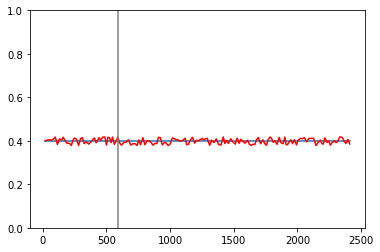

In [1944]:
plt.plot(tempdf["timestamp"], tempdf["trend"])
plt.plot(tempdf["timestamp"], tempdf["quality"], color = "red")
plt.axvline(tempdf["treatment_time"][1], color = "gray")
plt.ylim(0,1)


plt.show()

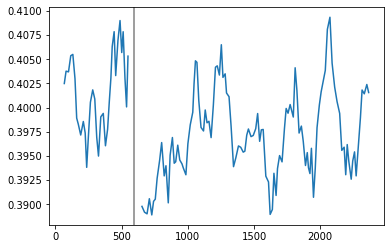

In [1945]:
plt.plot(tempdf["timestamp"], tempdf["quality_ma"])
plt.axvline(tempdf["treatment_time"][1], color = "gray")

In [1946]:
liste = [16.535156176028543,10.39885023883279,19.841230583054973,18.106803170201882,15.960678028293717,15.9926363891825,10.406527278239114,17.540936936079135,12.703261012272982,10.164099872092635]
print(liste[0:5], liste[5:10])
print(liste[-1:])
#print(create_pers_wordlist(liste,"a"))

[16.535156176028543, 10.39885023883279, 19.841230583054973, 18.106803170201882, 15.960678028293717] [15.9926363891825, 10.406527278239114, 17.540936936079135, 12.703261012272982, 10.164099872092635]
[10.164099872092635]


In [1947]:
np.floor(123124.23125)

123124.0